In [1]:
import torch 
import pandas as pd 
import pickle
import numpy as np
import os
import sys 

from torch.utils.data import Dataset, DataLoader
from torch import nn


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import trange

sns.set_theme()

In [665]:
# Load data
freq_data = np.genfromtxt("TTF_Data_100.000_1.500_2.500.csv.csv")

# Load pickle
with open("TTF_data.pt", "rb") as f:
    TTF_data = pickle.load(f)

with open("Vs_values.pt", "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

# Get Vs_data less than 800
index = Vs_data <= 800
TTF_data = TTF_data[index]
Vs_data = Vs_data[index]

print(TTF_data.shape, Vs_data.shape)

# Use only certain freq
idx = 0
freq = freq_data[:]

(146, 256) (146,)


# Load models

## Model 1

In [668]:
# Create Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU, batch_norm=False):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        if self.batch_norm:
            self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            if self.batch_norm:
                self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.out = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = layer(x)
                x = self.activation()(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
        x = self.out(x)
        return x

In [669]:
model_1 = MLP(31, 30, 4, output_dim=1, activation=nn.ReLU, batch_norm=True)

# Load model
model_1.load_state_dict(torch.load("MLP_TF_model.pt"))

model_1.eval()

MLP(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=31, out_features=30, bias=True)
    (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=30, out_features=30, bias=True)
    (7): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (out): Linear(in_features=30, out_features=1, bias=True)
)

## Model 2

In [670]:
# Define Transformer
class Transformer(nn.Module):
    def __init__(self, encoder_hidden_dim, encoder_hidden_size, decoder_hidden_dim, decoder_hidden_size, input_dim, output_dim, latent_dim):
        super(Transformer, self).__init__()

        self.encoder = MLP(input_dim, encoder_hidden_dim, encoder_hidden_size, latent_dim, batch_norm=True)
        self.decoder = MLP(latent_dim, decoder_hidden_dim, decoder_hidden_size, output_dim, batch_norm=True)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [671]:
model_2 = model = Transformer(128, 3, 128, 3, 30, 256, 50)

# Load model
model_2.load_state_dict(torch.load("transformer_model.pt"))

model_2.eval()

Transformer(
  (encoder): MLP(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=30, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (out): Linear(in_features=128, out_features=50, bias=True)
  )
  (decoder): MLP(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=50, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Linear(in_features=128,

# Evaluate models

In [672]:
freq_values = normalize_data(freq_data, mean_freq, std_freq)

In [673]:
# Data to use - test_Vs_data, test_TTF_data

output_data = []
output_data_2 = []
target = []
with torch.no_grad():
    for i in range(test_Vs_data.shape[0]):
        print(f"Processing {i+1}/{test_Vs_data.shape[0]} for Vs = {test_Vs_data[i]} ...")
        Vs_val = Vs_values_2[i] * np.ones(30)
        TTF_val = TTF_values_2[i,:]
        # Model 1 - requires iteration with all frequencies
        predictions = []
        for j in range(freq_values.shape[0]):
            freq_val = freq_values[j] * np.ones(1)
            input_data = torch.tensor(np.concatenate((Vs_val, freq_val)).reshape(1, 31), dtype=torch.float32)
            output = model_1(input_data)
            output = denormalize_data(output.numpy(), mean_TTF, std_TTF)
            predictions.append(output)

        output_data.append(np.concatenate(predictions).reshape(-1, 1))

        # Model 2 - requires only one iteration
        input_data = torch.tensor(Vs_val.reshape(1, 30), dtype=torch.float32)
        output = model_2(input_data)
        output = denormalize_data(output.numpy(), mean_TTF, std_TTF)
        output_data_2.append(output.reshape(-1, 1))

        # Target
        TTF_val = denormalize_data(TTF_val, mean_TTF, std_TTF)
        target.append(TTF_val.reshape(-1, 1))

        
        
    


Processing 1/140 for Vs = 374.148 ...


Processing 2/140 for Vs = 244.289 ...
Processing 3/140 for Vs = 561.723 ...
Processing 4/140 for Vs = 614.629 ...
Processing 5/140 for Vs = 739.679 ...
Processing 6/140 for Vs = 172.144 ...
Processing 7/140 for Vs = 162.525 ...
Processing 8/140 for Vs = 186.573 ...
Processing 9/140 for Vs = 532.866 ...
Processing 10/140 for Vs = 388.577 ...
Processing 11/140 for Vs = 253.908 ...
Processing 12/140 for Vs = 633.868 ...
Processing 13/140 for Vs = 672.345 ...
Processing 14/140 for Vs = 504.008 ...
Processing 15/140 for Vs = 215.431 ...
Processing 16/140 for Vs = 311.623 ...
Processing 17/140 for Vs = 470.341 ...
Processing 18/140 for Vs = 436.673 ...
Processing 19/140 for Vs = 441.483 ...
Processing 20/140 for Vs = 277.956 ...
Processing 21/140 for Vs = 340.481 ...
Processing 22/140 for Vs = 677.154 ...
Processing 23/140 for Vs = 220.24 ...
Processing 24/140 for Vs = 258.717 ...
Processing 25/140 for Vs = 460.721 ...
Processing 26/140 for Vs = 600.2 ...
Processing 27/140 for Vs = 282.766 .

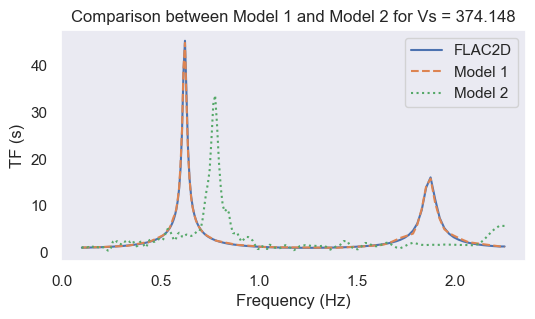

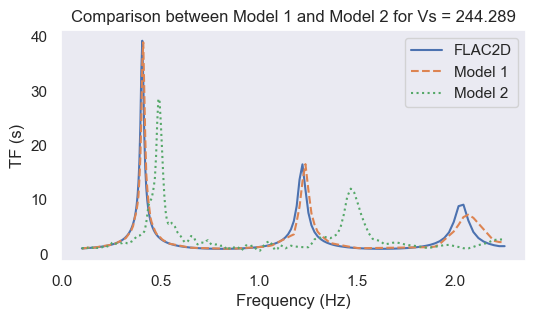

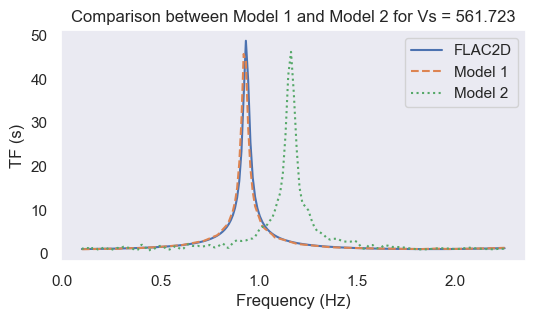

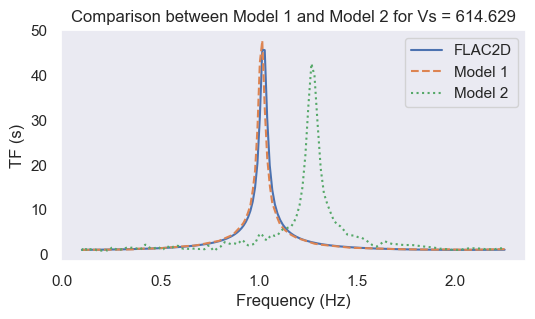

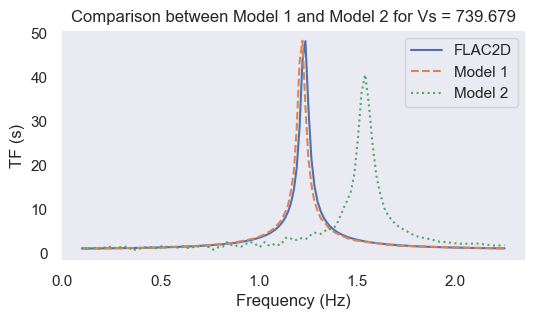

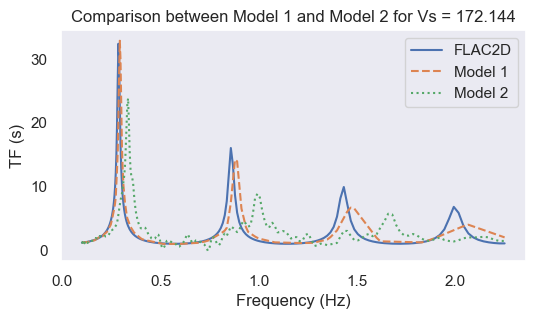

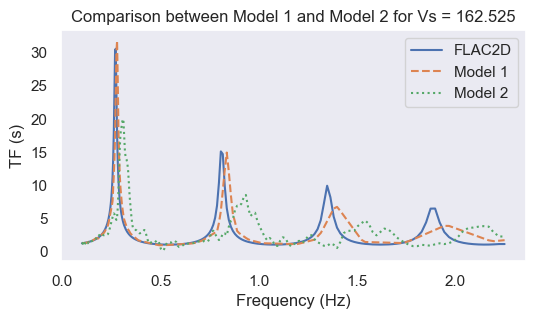

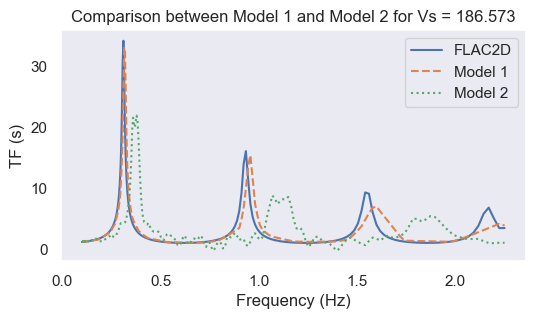

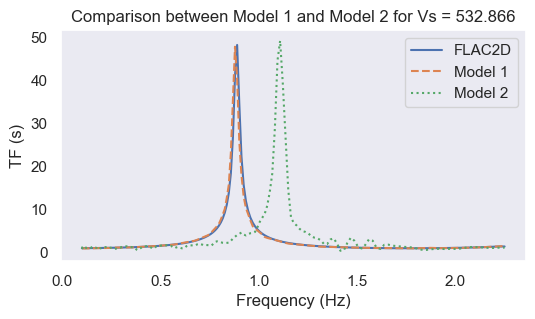

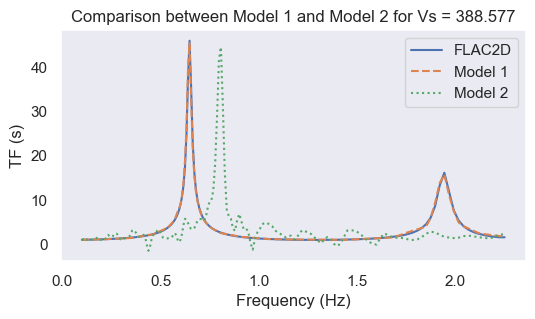

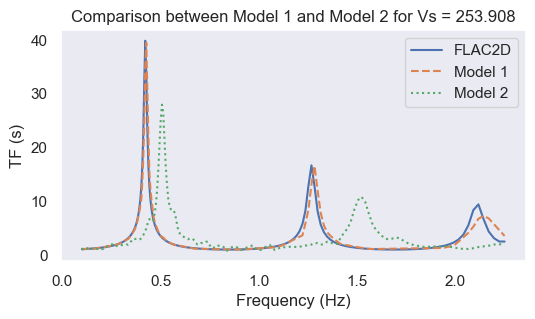

In [674]:
for i in range(test_Vs_data.shape[0]):
    fig, axs = plt.subplots(1, 1, figsize=(6, 3))

    axs.plot(freq_data, test_TTF_data[i], label=f"FLAC2D")
    axs.plot(freq_data, output_data[i], label=f"Model 1", linestyle="--")  
    axs.plot(freq_data, output_data_2[i], label=f"Model 2", linestyle=":")
    
    axs.legend()

    if i <= 10:
        axs.set_title("Comparison between Model 1 and Model 2 for Vs = {}".format(test_Vs_data[i]))
        axs.set_xlabel("Frequency (Hz)")
        axs.set_ylabel("TF (s)")
        axs.grid()
        plt.show()
        
    if i == 10:
        break
    

In [675]:
# Compute goodness of fit 
output_data = np.array(output_data)
output_data_2 = np.array(output_data_2)
target = np.array(target)

# Compute Correlation Coefficient
def compute_correlation_coefficient(output, target):
    output = output.reshape(-1)
    target = target.reshape(-1)
    return np.corrcoef(output, target)[0, 1]

# Compute  
correlation_coefficient = []
correlation_coefficient_2 = []

for i in range(test_Vs_data.shape[0]):
    correlation_coefficient.append(compute_correlation_coefficient(output_data[i], target[i]))
    correlation_coefficient_2.append(compute_correlation_coefficient(output_data_2[i], target[i]))

correlation_coefficient = np.array(correlation_coefficient)
correlation_coefficient_2 = np.array(correlation_coefficient_2)

print(f"Correlation Coefficient for Model 1: {correlation_coefficient.mean()}")
print(f"Correlation Coefficient for Model 2: {correlation_coefficient_2.mean()}")

Correlation Coefficient for Model 1: 0.9440132639413464
Correlation Coefficient for Model 2: 0.11504265253949474


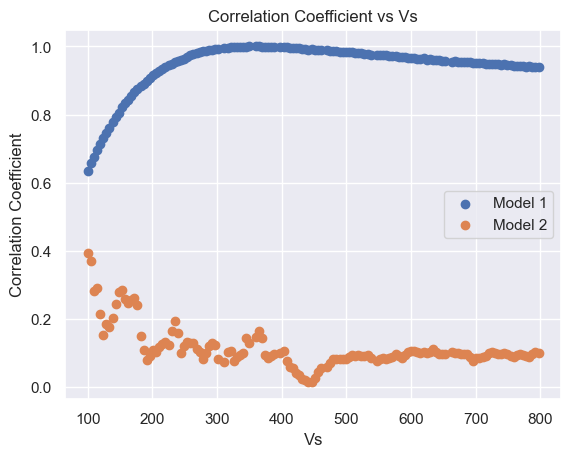

In [676]:
plt.scatter(test_Vs_data,correlation_coefficient, label="Model 1")
plt.scatter(test_Vs_data,correlation_coefficient_2, label="Model 2")
plt.legend()
plt.xlabel("Vs")
plt.ylabel("Correlation Coefficient")
plt.title("Correlation Coefficient vs Vs")
plt.show()

In [677]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming output_data, output_data_2, and test_TTF_data are already defined

# Initialize lists to store the goodness-of-fit measures
mae_model_1 = []
mse_model_1 = []
rmse_model_1 = []
r2_model_1 = []

mae_model_2 = []
mse_model_2 = []
rmse_model_2 = []
r2_model_2 = []

# Calculate goodness-of-fit measures for each sample
for i in range(test_TTF_data.shape[0]):
    mae_model_1.append(mean_absolute_error(test_TTF_data[i], output_data[i]))
    mse_model_1.append(mean_squared_error(test_TTF_data[i], output_data[i]))
    rmse_model_1.append(np.sqrt(mean_squared_error(test_TTF_data[i], output_data[i])))
    r2_model_1.append(r2_score(test_TTF_data[i], output_data[i]))

    mae_model_2.append(mean_absolute_error(test_TTF_data[i], output_data_2[i]))
    mse_model_2.append(mean_squared_error(test_TTF_data[i], output_data_2[i]))
    rmse_model_2.append(np.sqrt(mean_squared_error(test_TTF_data[i], output_data_2[i])))
    r2_model_2.append(r2_score(test_TTF_data[i], output_data_2[i]))

# Convert lists to numpy arrays for easier plotting
mae_model_1 = np.array(mae_model_1)
mse_model_1 = np.array(mse_model_1)
rmse_model_1 = np.array(rmse_model_1)
r2_model_1 = np.array(r2_model_1)

mae_model_2 = np.array(mae_model_2)
mse_model_2 = np.array(mse_model_2)
rmse_model_2 = np.array(rmse_model_2)
r2_model_2 = np.array(r2_model_2)

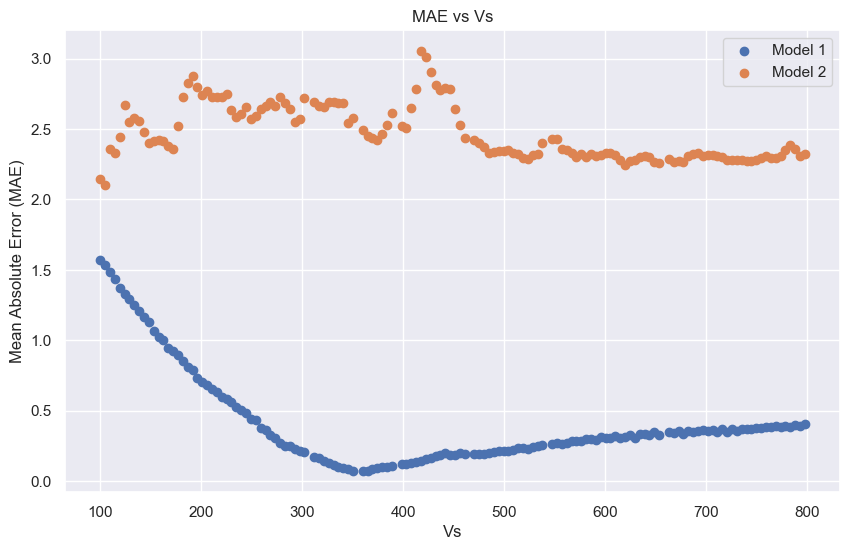

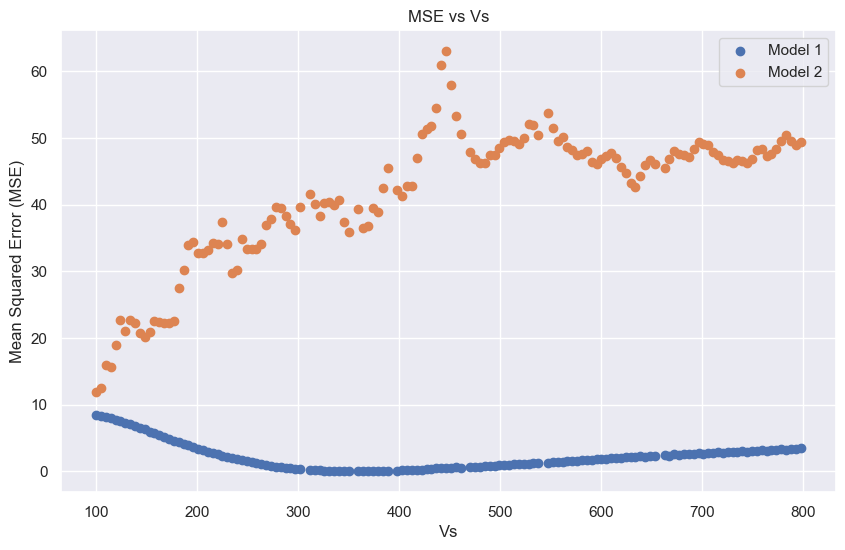

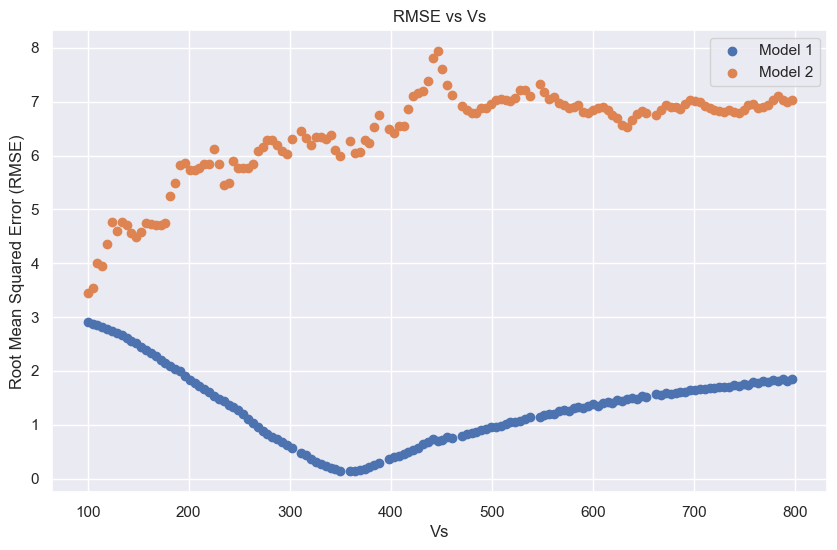

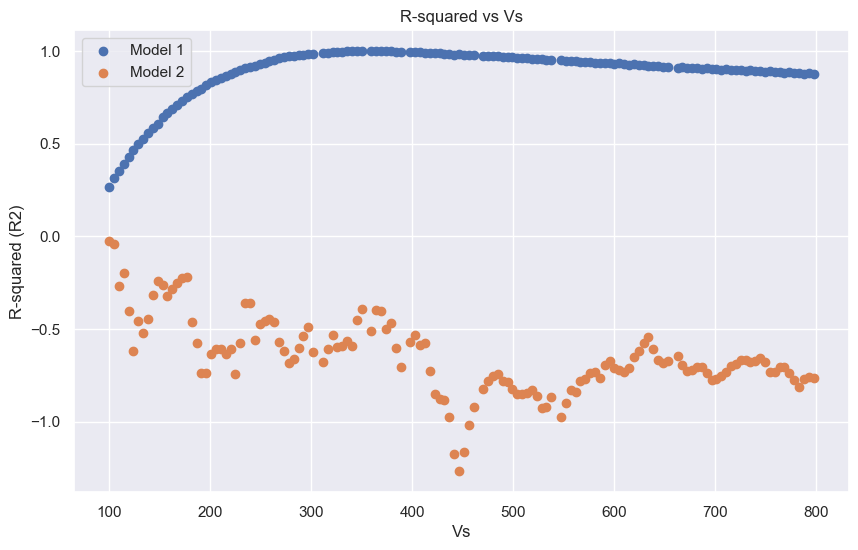

In [678]:
import matplotlib.pyplot as plt

# Plotting MAE
plt.figure(figsize=(10, 6))
plt.scatter(test_Vs_data, mae_model_1, label="Model 1")
plt.scatter(test_Vs_data, mae_model_2, label="Model 2")
plt.legend()
plt.xlabel("Vs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE vs Vs")
plt.show()

# Plotting MSE
plt.figure(figsize=(10, 6))
plt.scatter(test_Vs_data, mse_model_1, label="Model 1")
plt.scatter(test_Vs_data, mse_model_2, label="Model 2")
plt.legend()
plt.xlabel("Vs")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs Vs")
plt.show()

# Plotting RMSE
plt.figure(figsize=(10, 6))
plt.scatter(test_Vs_data, rmse_model_1, label="Model 1")
plt.scatter(test_Vs_data, rmse_model_2, label="Model 2")
plt.legend()
plt.xlabel("Vs")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("RMSE vs Vs")
plt.show()

# Plotting R-squared
plt.figure(figsize=(10, 6))
plt.scatter(test_Vs_data, r2_model_1, label="Model 1")
plt.scatter(test_Vs_data, r2_model_2, label="Model 2")
plt.legend()
plt.xlabel("Vs")
plt.ylabel("R-squared (R2)")
plt.title("R-squared vs Vs")
plt.show()